In [1]:
# Installing the modules.
!pip install -q tensorflow==2.3
!pip install albumentations -q
!pip install pymorphy2
!pip install pymorphy2-dicts

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stumpy 1.8.0 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
sklearn-pandas 2.1.0 requires scipy>=1.5.1, but you have scipy 1.4.1 which is incompatible.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.18.5 which is incompatible.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.
phik 0.11.2 requires scipy>=1.5.2, but you have scipy 1.4.1 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.1 which is incompatible.
osmnx 1.0.1 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
matrixprofile 1.1.10 requires protobuf==3

# 1. Установка необходимых библиотек

In [2]:
# Importing modules.
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import albumentations
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pylab import rcParams
from itertools import combinations
from scipy.stats import ttest_ind

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.3.0


In [3]:
# Установка праметров
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

!pip freeze > requirements.txt

In [4]:
# функция для расчета mape
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# импорт datasets
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [6]:
train.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

# 2. Наивное прогнозирование

Эта модель позволяет прогнозировать среднюю цену в зависимости от модели автомобиля и года выпуска. С ним будем сравнивать другие модели.

In [7]:
# Подготовка данных для обучения
data_train, data_test = train_test_split(
    train,
    test_size=0.15,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [8]:
# наивное прогнозирование
predicts = []

for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    
    predicts.append(data_train[(data_train.model_info == row[0]) & (data_train.productionDate == row[1])]['price'].median())
    
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())
predicts = (predicts // 1000) * 1000

print(f"MAPE for Naive Forecasting: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

MAPE for Naive Forecasting: 19.88%


# 3. EDA

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

Вывод
------

Есть только 2 столбца с пропущенными значениями. Столбец «Владение» можно опустить, так как он, вероятно, сильно коррелирует с годом выпуска. Также пропущено одно значение в графе «Владельцы» (количество владельцев). Его будет проще заполнить вручную.

In [10]:
train[train['Владельцы'].isna()].productionDate

4994    2001
Name: productionDate, dtype: int64

In [11]:
train[train.productionDate == 2001]['Владельцы'].describe()


count              53
unique              3
top       3 или более
freq               46
Name: Владельцы, dtype: object

In [12]:
train['Владельцы'] = train['Владельцы'].fillna('3 или более')

Вывод
-----
Пропущенное значение лучше заменнить "3 или более"

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

Вывод
------
Так как не будем использовать столбец "Владение", все столбцы заполнены

In [14]:
test.duplicated().sum()

0

In [15]:
train.duplicated().sum()

0

In [16]:
# объединим таблицы
train['sample'] = 1
test['sample'] = 0
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)

In [17]:
data.info()
data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0


## 3.1 Body Type

In [18]:
data['bodyType'].value_counts()

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

## 3.2 Brand

In [19]:
data['brand'].value_counts()

BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

## 3.3 Сolor

In [20]:
data['color'].value_counts()

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

## 3.4 Description

In [21]:
data['description'][1]

'Продаю любимейшую тачилу.. Обвес и тюнинг Hamman. Потому что совсем на ней не езжу, а она должна резвиться и служить. Авто с хорошей кармой. С хорошим звуком и вообще приятнейшая. \n\nИз-за частых командировок машиной не пользовалась, отсюда и такой маленький пробег. Были 2 мелких аварии (не увидела столбик во дворе и ещё раз не увидела, но сделала ремонт и все части поврежденные отремонтировала).\n\nНа фото летняя резина на родных дисках, а у меня есть ещё зимняя резина на супер красивых дисках! Отдам вместе с машиной бонусом. Если купит девушка - то с меня патчи и блеск для губ ❤️'

## 3.5 Engine Displacement

In [22]:
data['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
3.1 LTR            44
2.4 LTR            44
6.2 LTR            40
6.0 LTR            37
1.2 LTR            33
5.4 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
4.6 LTR             5
6.6 LTR             5
5.8 LTR             5
1.9 LTR             5
4.3 LTR             4
3.4 LTR             4
5.6 LTR             3
6.3 LTR   

Вывод
------
Так как у нас есть данные неидентифицированные, то заменим их модой

In [23]:
data.loc[data['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '2.0 LTR'

In [24]:
data['engineDisplacement'] = data['engineDisplacement'].str.split().apply(lambda s: s[0])

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda s: float(s))

data['engineDisplacement'] = data['engineDisplacement']*1000

## 3.6 Engine Power

In [25]:
data['enginePower'].value_counts()

184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
165 N12      1
133 N12      1
700 N12      1
402 N12      1
100 N12      1
Name: enginePower, Length: 154, dtype: int64

In [26]:
data['enginePower'] = data['enginePower'].str.split().apply(lambda s: s[0])

data['enginePower'] = data['enginePower'].apply(lambda s: float(s))

## 3.7 Fuel Type

In [27]:
data['fuelType'].value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

## 3.8 Mileage

<AxesSubplot:>

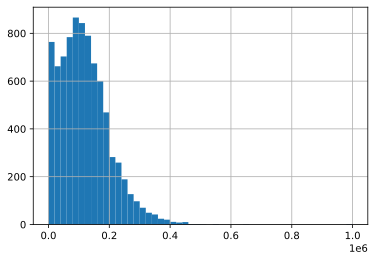

In [28]:
data['mileage'].hist(bins=50)

<AxesSubplot:>

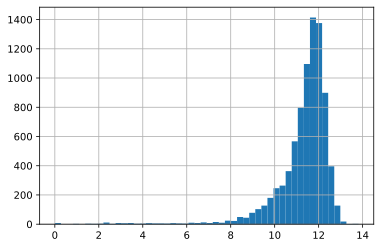

In [29]:
np.log(data['mileage']).hist(bins=50)

## 3.9 Model Date

<AxesSubplot:>

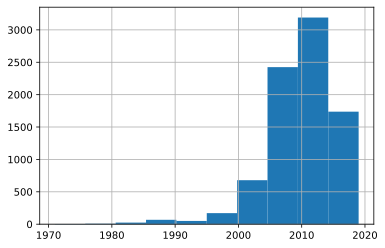

In [30]:
data['modelDate'].hist()

In [31]:
data['modelDate'] = 2021 - data['modelDate']

<AxesSubplot:>

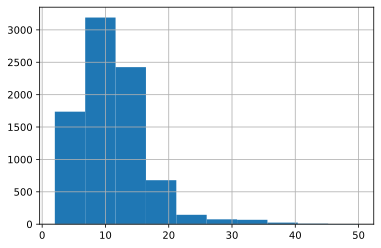

In [32]:
data['modelDate'].hist()

<AxesSubplot:>

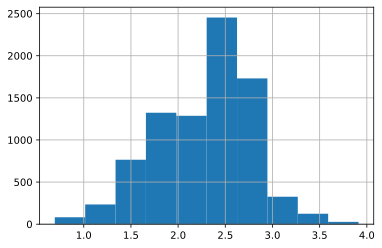

In [33]:
np.log(data['modelDate']).hist()

## 3.10 Model Info

In [34]:
data['model_info'].value_counts()

5ER               776
3ER               578
X5                501
E_KLASSE          490
A6                433
                 ... 
Z1                  1
X3_M                1
SLC_KLASSE_AMG      1
100                 1
Z8                  1
Name: model_info, Length: 122, dtype: int64

В списке есть несколько странных названий, давайте разберемся, что с ними не так.

In [35]:
data[data['model_info'] == '100']['description']

6275    Продаю S4 1994 года, последний год выпуска S4 ...
Name: description, dtype: object

In [36]:
print(data[data['model_info'] == 'COUPE']['description'])

1646    Собственник 10 лет в одних руках. Есть вся ист...
Name: description, dtype: object


In [37]:
data[data['model_info'] == 'None']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4000.0,510.0,бензин,41000,7,None,...,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,1,3700000.0


Мы выяснили, что '100' = 'S4', 'COUPE' = 'S2', 'None' = 'C_KLASSE_AMG'

In [38]:
data.loc[data['model_info'] == '100', 'model_info'] = 'S4'
data.loc[data['model_info'] == 'COUPE', 'model_info'] = 'S2'
data.loc[data['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'

## 3.11 Name

In [39]:
data['name']

0                    300 3.0 AT (220 л.с.)
1       640d xDrive 3.0d AT (313 л.с.) 4WD
2              325xi 2.5 AT (218 л.с.) 4WD
3                   318i 2.0 AT (136 л.с.)
4       520d xDrive 2.0d AT (190 л.с.) 4WD
                       ...                
8348                320i 2.0 AT (150 л.с.)
8349               520d 2.0d AT (190 л.с.)
8350                318i 2.0 AT (143 л.с.)
8351            Long 3.0 AT (310 л.с.) 4WD
8352             Pullman 6.0 AT (394 л.с.)
Name: name, Length: 8353, dtype: object

## 3.12 Number of Doors

<AxesSubplot:>

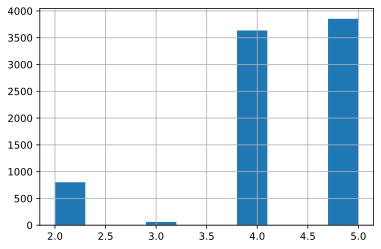

In [40]:
data['numberOfDoors'].hist()

## 3.13 Production Date

<AxesSubplot:>

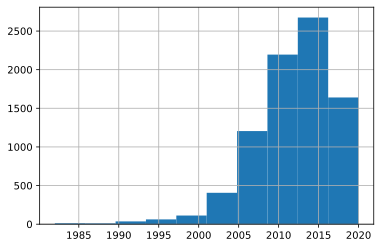

In [41]:
data['productionDate'].hist()

In [42]:
data['productionDate'] = 2021 - data['productionDate']

<AxesSubplot:>

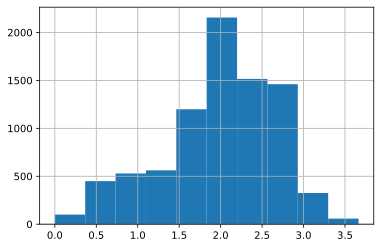

In [43]:
np.log(data['productionDate']).hist()

## 3.14 Sell ID

In [44]:
data['sell_id']

0       1099427284
1       1096405886
2       1100195294
3       1099827282
4       1100076198
           ...    
8348    1100036650
8349    1090506038
8350    1095155628
8351    1099625256
8352    1097146066
Name: sell_id, Length: 8353, dtype: int64

## 3.15 Vehicle Configuration

In [45]:
data['vehicleConfiguration']

0       WAGON_5_DOORS AUTOMATIC 3.0
1               COUPE AUTOMATIC 3.0
2               COUPE AUTOMATIC 2.5
3               SEDAN AUTOMATIC 2.0
4               SEDAN AUTOMATIC 2.0
                   ...             
8348            SEDAN AUTOMATIC 2.0
8349            SEDAN AUTOMATIC 2.0
8350            SEDAN AUTOMATIC 2.0
8351            SEDAN AUTOMATIC 3.0
8352        LIMOUSINE AUTOMATIC 6.0
Name: vehicleConfiguration, Length: 8353, dtype: object

## 3.16 Vehicle Transmission

<AxesSubplot:>

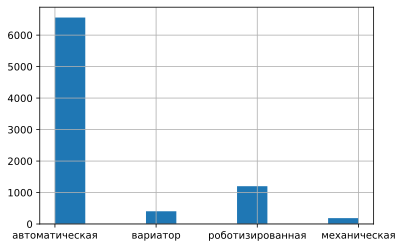

In [46]:
data['vehicleTransmission'].hist()

## 3.17 Owners

<AxesSubplot:>

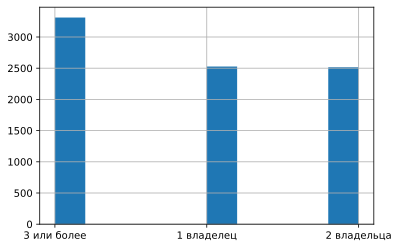

In [47]:
data['Владельцы'].hist()

In [48]:
owners_dict = {
    '1\xa0владелец': 1,
    '2\xa0владельца': 2,
    '3 или более': 3
}

data['Владельцы'] = data['Владельцы'].map(owners_dict)

<AxesSubplot:>

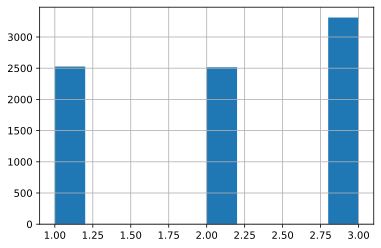

In [49]:
data['Владельцы'].hist()

## 3.18 Ownership Time

In [50]:
data['Владение'].value_counts(dropna=False)

NaN                    5418
1 год и 2 месяца         67
1 год и 8 месяцев        67
1 год                    55
2 года и 2 месяца        52
                       ... 
14 лет и 5 месяцев        1
16 лет и 1 месяц          1
29 лет и 7 месяцев        1
19 лет                    1
16 лет и 10 месяцев       1
Name: Владение, Length: 181, dtype: int64

## 3.19 Registration Certificate

<AxesSubplot:>

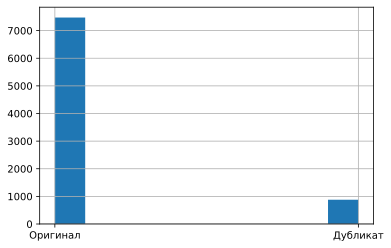

In [51]:
data['ПТС'].hist()

In [52]:
passport_dict = {
    'Дубликат': 0,
    'Оригинал': 1,
}

data['ПТС'] = data['ПТС'].map(passport_dict)

## 3.20 Car Layout

<AxesSubplot:>

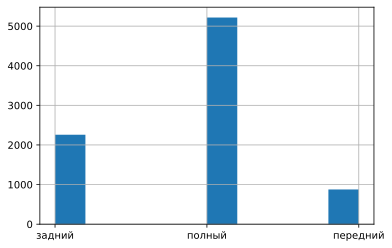

In [53]:
data['Привод'].hist()

In [54]:
drive_dict = {
    'задний': 0,
    'полный': 1,
    'передний': 2,
}

data['Привод'] = data['Привод'].map(drive_dict)

<AxesSubplot:>

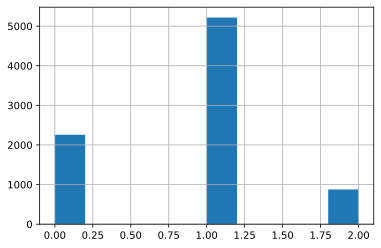

In [55]:
data['Привод'].hist()

## 3.21 Wheel Position

In [56]:
data['Руль'].value_counts()

Левый     8351
Правый       2
Name: Руль, dtype: int64

In [57]:
wheel_dict = {
    'Левый': 0,
    'Правый': 1,
    
}

data['Руль'] = data['Руль'].map(wheel_dict)

In [58]:
data['Руль'].value_counts()

0    8351
1       2
Name: Руль, dtype: int64

## 3.22 Price

<AxesSubplot:>

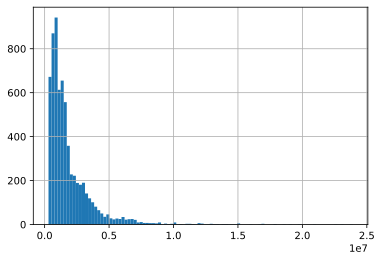

In [59]:
train['price'].hist(bins=100)

# 4. Feature Engineering

Создадим бинарный признак «популярный цвет», «редкий цвет» и «очень редкий цвет»

In [60]:
popular_colors = [
    'чёрный', 
    'белый', 
    'серый', 
    'синий'
]

rare_colors = [
    'серебристый',
    'коричневый',
    'красный'
]

data['popular_color'] = 0
data['rare_color'] = 0
data['very_rare_color'] = 0

In [61]:
counter = 0

for color in data['color']:
    if color in popular_colors:
        data.loc[counter,'popular_color'] = 1
        counter += 1
    elif color in rare_colors:
        data.loc[counter,'rare_color'] = 1
        counter += 1
    else:
        data.loc[counter,'very_rare_color'] = 1
        counter += 1

Создадим характеристику «Соотношение пробег / к возрасту автомобиля».

In [62]:
data['mileage_to_age'] = data['mileage']/data['productionDate']

# 5. Feature Selection

In [63]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   float64
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Владение,ПТС,Привод,Руль,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3000.0,220.0,бензин,350000,37,W124,...,6 лет и 3 месяца,1,0,0,0,0.0,1,0,0,11666.666667
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3000.0,313.0,дизель,15000,10,6ER,...,6 лет и 6 месяцев,1,1,0,0,0.0,1,0,0,1875.000000
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2500.0,218.0,бензин,166600,16,3ER,...,NaN,1,1,0,0,0.0,0,0,1,12815.384615
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2000.0,136.0,бензин,147000,16,3ER,...,NaN,1,0,0,0,0.0,1,0,0,10500.000000
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2000.0,190.0,дизель,24000,5,5ER,...,NaN,1,1,0,0,0.0,1,0,0,12000.000000


In [64]:
categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission',
    'Владельцы',
    'Привод'
]

numerical_features = [
    'engineDisplacement',
    'enginePower',
    'mileage', 
    'modelDate', 
    'productionDate',
    'numberOfDoors',
    'mileage_to_age'
]

binary_features = [
    'popular_color',
    'rare_color'
    'very_rare_color', 
    'Руль',
    'ПТС'
]

<AxesSubplot:>

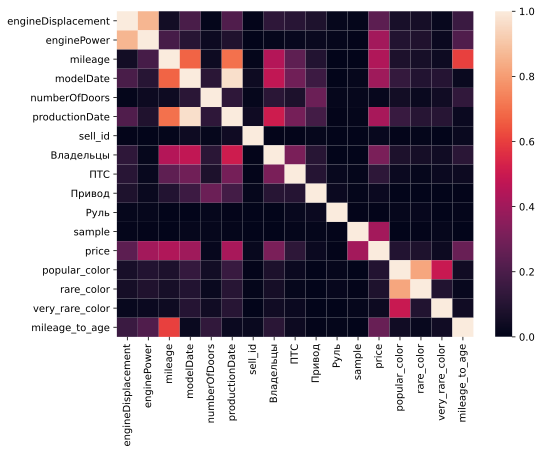

In [65]:
plt.subplots(figsize=(8,6))
sns.heatmap(data.corr().abs(), vmin=0, vmax=1)

In [66]:
data.corr().abs().sort_values(by='price', ascending=False)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,Владельцы,ПТС,Привод,Руль,sample,price,popular_color,rare_color,very_rare_color,mileage_to_age
price,0.241236,0.404552,0.436743,0.397267,0.018068,0.417464,0.019779,0.309139,0.118204,0.030448,0.004501,0.405771,1.000000,0.090281,0.081155,0.034027,0.269509
mileage,0.048958,0.184616,1.000000,0.672522,0.038435,0.702970,0.010300,0.444289,0.245004,0.093594,0.002322,0.003900,0.436743,0.074997,0.061223,0.037765,0.601572
productionDate,0.209635,0.085100,0.702970,0.964919,0.124278,1.000000,0.042841,0.507794,0.298051,0.177728,0.006093,0.008146,0.417464,0.150023,0.105450,0.101656,0.027846
sample,0.009046,0.004199,0.003900,0.011782,0.014501,0.008146,0.000134,0.003877,0.008624,0.009810,0.007739,1.000000,0.405771,0.003183,0.005860,0.014577,0.003277
enginePower,0.860391,1.000000,0.184616,0.101825,0.031772,0.085100,0.000859,0.012214,0.019801,0.025951,0.012872,0.004199,0.404552,0.089958,0.084783,0.027894,0.209323
modelDate,0.195043,0.101825,0.672522,1.000000,0.112091,0.964919,0.038045,0.475524,0.285476,0.157482,0.003141,0.011782,0.397267,0.136801,0.092767,0.097896,0.023480
Владельцы,0.121488,0.012214,0.444289,0.475524,0.112461,0.507794,0.004910,1.000000,0.311522,0.104298,0.001753,0.003877,0.309139,0.075965,0.056501,0.046710,0.113091
mileage_to_age,0.153586,0.209323,0.601572,0.023480,0.130783,0.027846,0.024568,0.113091,0.032032,0.005526,0.009054,0.003277,0.269509,0.043919,0.020602,0.045512,1.000000
engineDisplacement,1.000000,0.860391,0.048958,0.195043,0.011355,0.209635,0.006141,0.121488,0.105526,0.078476,0.012883,0.009046,0.241236,0.063396,0.057723,0.022765,0.153586
ПТС,0.105526,0.019801,0.245004,0.285476,0.077261,0.298051,0.006258,0.311522,1.000000,0.099526,0.019909,0.008624,0.118204,0.027725,0.011888,0.030444,0.032032


In [67]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (10, 14))
    sns.boxplot(x=column, 
                y='price',
                data=train.loc[
                    train.loc[:, column].isin(train.loc[:, column].value_counts().index[:10])
                ],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

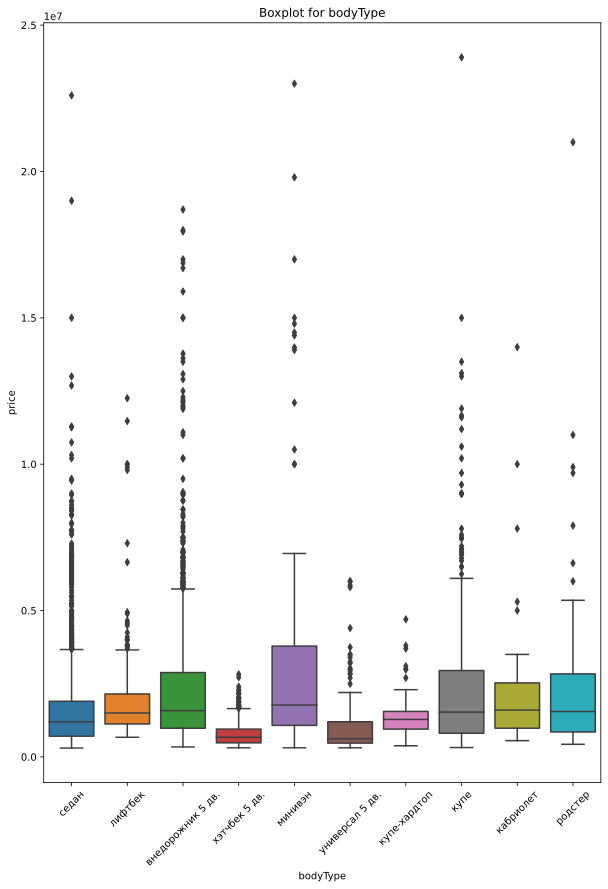

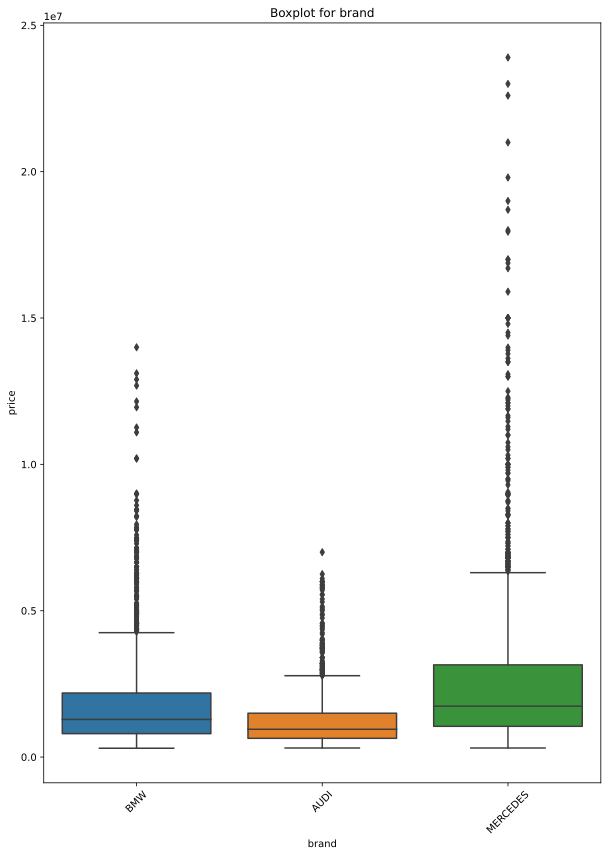

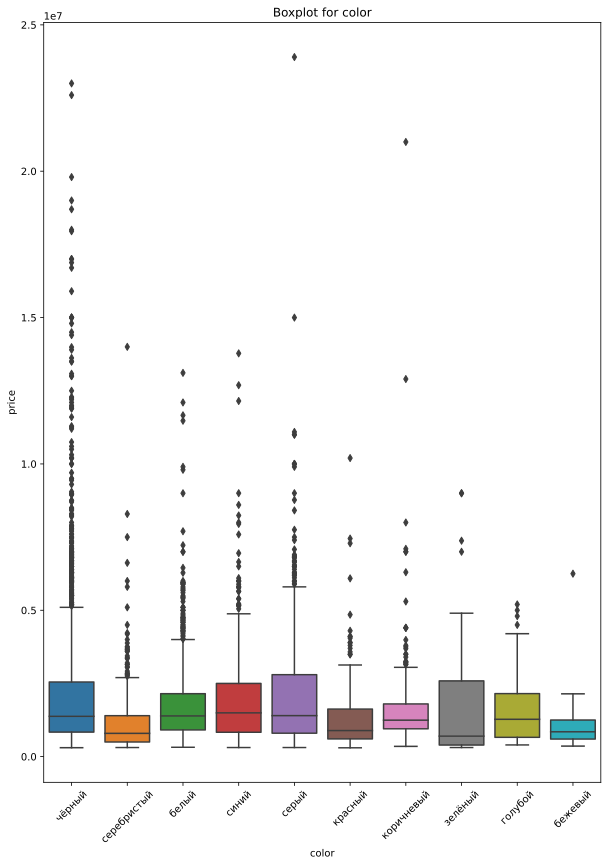

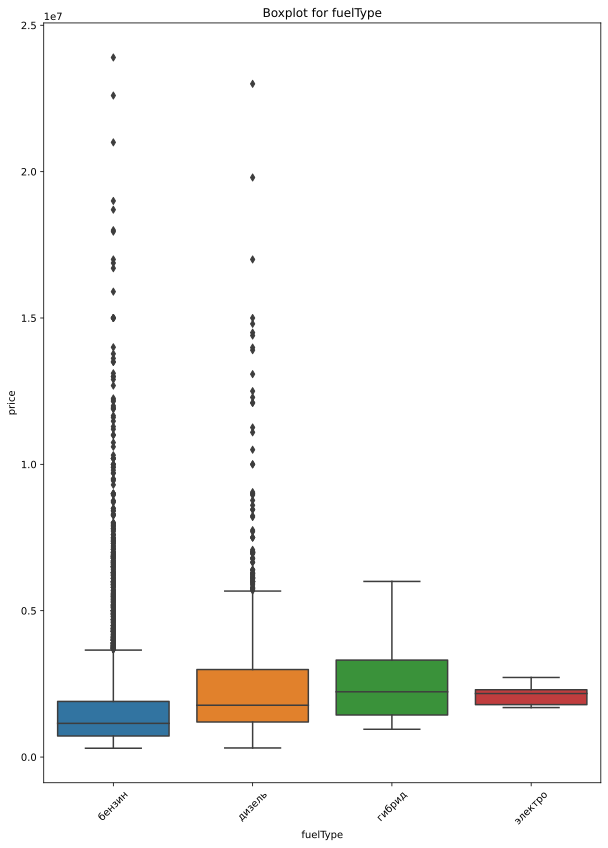

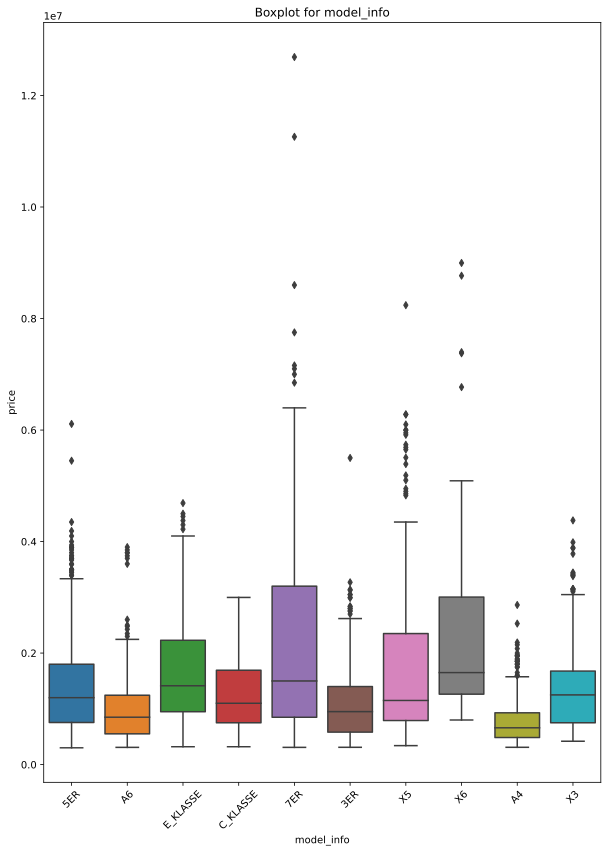

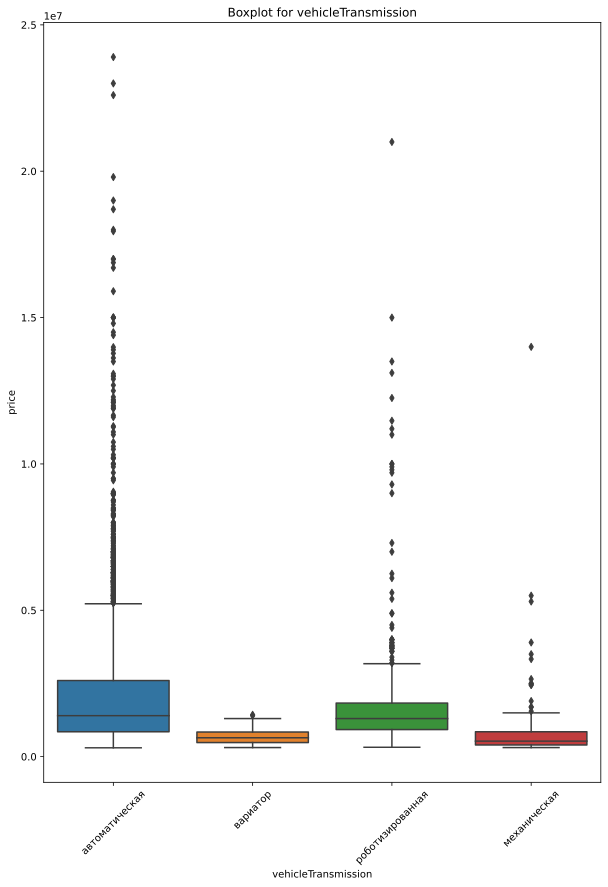

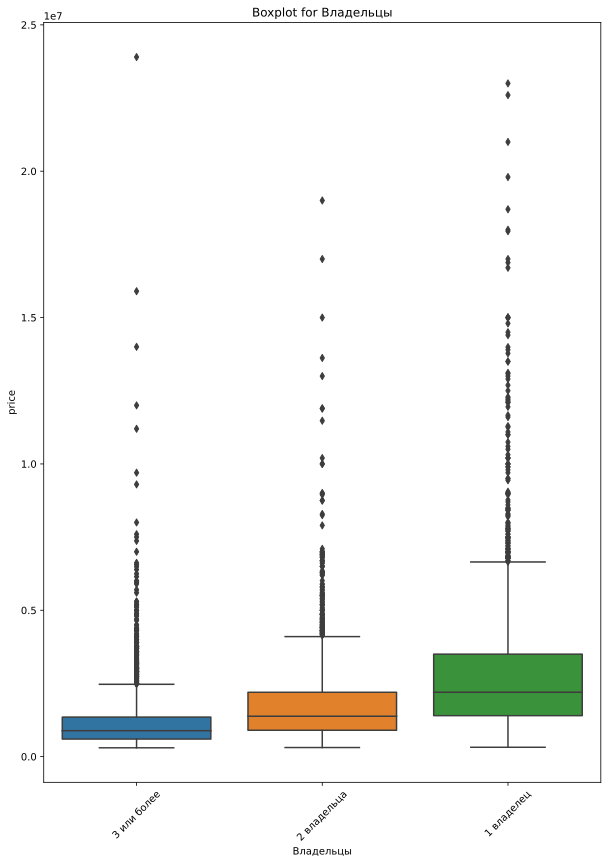

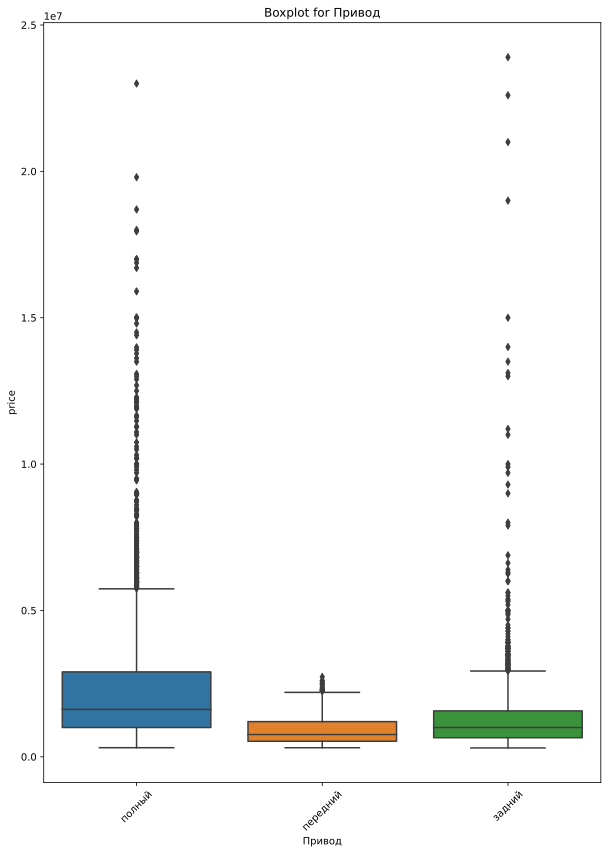

In [68]:
for col in categorical_features: 
    get_boxplot(col)

In [69]:
def get_stat_dif(column):
    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all):
            print('Statistically significant differences were found for the column', column)
            break

In [70]:
for col in categorical_features:
    get_stat_dif(col)

Statistically significant differences were found for the column bodyType
Statistically significant differences were found for the column brand
Statistically significant differences were found for the column color
Statistically significant differences were found for the column fuelType
Statistically significant differences were found for the column model_info
Statistically significant differences were found for the column vehicleTransmission
Statistically significant differences were found for the column Владельцы
Statistically significant differences were found for the column Привод


# 4. Data Pre-processing

In [71]:
def preproc_data(df_input):

    # Copying the data.
    df_output = df_input.copy()
    
    # Dropping useless data.
    df_output.drop([
        'description',
        'name',
        'sell_id',
        'vehicleConfiguration',
        'Владение'
    ], axis = 1, inplace=True)
    
    # Taking the logarithm.
    data['enginePower'] = np.log(data['enginePower'])
    data['mileage'] = np.log(data['mileage'])
    data['engineDisplacement'] = np.log(data['enginePower'])
    data['modelDate'] = np.log(data['mileage'])
    data['productionDate'] = np.log(data['mileage'])
    
    # Data normalization.
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # One-hot encoding.
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    df_output = pd.get_dummies(
        df_output, 
        columns=categorical_features, 
        dummy_na=False
    )
    
    return df_output

In [72]:
df_preproc = preproc_data(data)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [73]:
df_preproc.info()
df_preproc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 184 entries, engineDisplacement to Привод_2
dtypes: float64(8), int64(6), uint8(170)
memory usage: 2.2 MB


,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,ПТС,Руль,sample,price,...,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Привод_0,Привод_1,Привод_2
0,0.389831,0.2320,0.349999,0.729167,1.000000,0.763158,1,0,0,0.0,...,1,0,0,0,0,0,1,1,0,0
1,0.389831,0.3808,0.014999,0.166667,0.000000,0.184211,1,0,0,0.0,...,1,0,0,0,1,0,0,0,1,0
2,0.305085,0.2288,0.166599,0.291667,0.000000,0.315789,1,0,0,0.0,...,1,0,0,0,0,0,1,0,1,0
3,0.220339,0.0976,0.146999,0.291667,0.666667,0.342105,1,0,0,0.0,...,1,0,0,0,0,1,0,1,0,0
4,0.220339,0.1840,0.023999,0.062500,0.666667,0.026316,1,0,0,0.0,...,1,0,0,0,1,0,0,0,1,0


# 5. CatBoost (Model 2)

In [74]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED
)

In [75]:
"""model = CatBoostRegressor(
    iterations=20000,
    random_seed=RANDOM_SEED,
    eval_metric='MAPE',
    custom_metric=['RMSE', 'MAE'],
    od_wait=500
)
                          
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose_eval=100,
    use_best_model=True
)

test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")"""

'model = CatBoostRegressor(\n    iterations=20000,\n    random_seed=RANDOM_SEED,\n    eval_metric=\'MAPE\',\n    custom_metric=[\'RMSE\', \'MAE\'],\n    od_wait=500\n)\n                          \nmodel.fit(\n    X_train,\n    y_train,\n    eval_set=(X_test, y_test),\n    verbose_eval=100,\n    use_best_model=True\n)\n\ntest_predict_catboost = model.predict(X_test)\nprint(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")'

In [76]:
"""sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)"""

"sub_predict_catboost = model.predict(X_sub)\nsample_submission['price'] = sub_predict_catboost\nsample_submission.to_csv('catboost_submission.csv', index=False)"

# 6. Tabular NN (Model 3)

In [77]:
"""model = Sequential()

model.add(L.Dense(
    512, 
    input_dim=X_train.shape[1], 
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="relu"
))

model.add(L.Dropout(0.5))

model.add(L.Dense(
    256,
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="relu"
))

model.add(L.Dropout(0.5))

model.add(L.Dense(1, activation="linear"))"""

'model = Sequential()\n\nmodel.add(L.Dense(\n    512, \n    input_dim=X_train.shape[1], \n    kernel_regularizer=regularizers.l1_l2(\n        l1=0.000000001, \n        l2=0.000000001\n    ), \n    activation="relu"\n))\n\nmodel.add(L.Dropout(0.5))\n\nmodel.add(L.Dense(\n    256,\n    kernel_regularizer=regularizers.l1_l2(\n        l1=0.000000001, \n        l2=0.000000001\n    ), \n    activation="relu"\n))\n\nmodel.add(L.Dropout(0.5))\n\nmodel.add(L.Dense(1, activation="linear"))'

In [78]:
"""model.summary()"""

'model.summary()'

In [79]:
from keras import optimizers

In [80]:
"""sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='MAPE', metrics=['MAPE'])
epochs = 500"""

"sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)\nmodel.compile(optimizer=sgd, loss='MAPE', metrics=['MAPE'])\nepochs = 500"

In [81]:
"""checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]"""

"checkpoint = ModelCheckpoint(\n    '../working/best_model.hdf5', \n    monitor=['val_MAPE'], \n    verbose=0, \n    mode='min'\n)\n\nearlystop = EarlyStopping(\n    monitor='val_MAPE', \n    patience=50, \n    restore_best_weights=True\n)\n\ncallbacks_list = [checkpoint, earlystop]"

In [82]:
"""history = model.fit(X_train, y_train, 
                 validation_data=(X_test, y_test), shuffle=True, 
                 epochs=epochs, batch_size=20, callbacks=callbacks_list)"""

'history = model.fit(X_train, y_train, \n                 validation_data=(X_test, y_test), shuffle=True, \n                 epochs=epochs, batch_size=20, callbacks=callbacks_list)'

In [83]:
"""mape = history.history['MAPE']
val_mape = history.history['val_MAPE']
epochs = range(len(mape))

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title('Training and validation MAPE')
plt.legend()
 
plt.figure()"""

"mape = history.history['MAPE']\nval_mape = history.history['val_MAPE']\nepochs = range(len(mape))\n\nplt.plot(epochs, mape, 'b', label='Training MAPE')\nplt.plot(epochs, val_mape, 'r', label='Validation MAPE')\nplt.title('Training and validation MAPE')\nplt.legend()\n \nplt.figure()"

In [84]:
"""model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')"""

"model.load_weights('../working/best_model.hdf5')\nmodel.save('../working/nn_1.hdf5')"

In [85]:
"""sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)"""

"sub_predict_nn1 = model.predict(X_sub)\nsample_submission['price'] = sub_predict_nn1[:,0]\nsample_submission.to_csv('nn1_submission.csv', index=False)"

# 7. Multiple Input NLP (Model 4)

In [86]:
"""morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)"""

'morph = pymorphy2.MorphAnalyzer()\ndf_NLP = data.copy()\n\npatterns = "[A-Za-z0-9!#$%&\'()*+,./:;<=>?@[\\]^_`{|}~—"\\-]+"\n\ndef lemmatize(doc):\n    doc = re.sub(patterns, \' \', doc)\n    tokens = []\n    for token in doc.split():\n        token = token.strip()\n        token = morph.normal_forms(token)[0]\n        tokens.append(token)\n    return \' \'.join(tokens)'

In [87]:
"""df_NLP['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)"""

"df_NLP['description'] = df_NLP.apply(\n    lambda df_NLP: lemmatize(df_NLP.description), axis=1)"

In [88]:
"""text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]"""

'text_train = data.description.iloc[X_train.index]\ntext_test = data.description.iloc[X_test.index]\ntext_sub = data.description.iloc[X_sub.index]'

In [89]:
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 256

"""tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)"""

'tokenize = Tokenizer(num_words=MAX_WORDS)\ntokenize.fit_on_texts(data.description)'

In [90]:
"""text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), 
    maxlen=MAX_SEQUENCE_LENGTH
)

text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), 
    maxlen=MAX_SEQUENCE_LENGTH
)

print(
    text_train_sequences.shape, 
    text_test_sequences.shape, 
    text_sub_sequences.shape
)"""

'text_train_sequences = sequence.pad_sequences(\n    tokenize.texts_to_sequences(text_train), \n    maxlen=MAX_SEQUENCE_LENGTH\n)\n\ntext_test_sequences = sequence.pad_sequences(\n    tokenize.texts_to_sequences(text_test), \n    maxlen=MAX_SEQUENCE_LENGTH\n)\n\ntext_sub_sequences = sequence.pad_sequences(\n    tokenize.texts_to_sequences(text_sub), \n    maxlen=MAX_SEQUENCE_LENGTH\n)\n\nprint(\n    text_train_sequences.shape, \n    text_test_sequences.shape, \n    text_sub_sequences.shape\n)'

In [91]:
"""text_sub_sequences[0]"""

'text_sub_sequences[0]'

In [92]:
"""model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))"""

'model_nlp = Sequential()\nmodel_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))\nmodel_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))\nmodel_nlp.add(L.LSTM(256, return_sequences=True))\nmodel_nlp.add(L.Dropout(0.5))\nmodel_nlp.add(L.LSTM(128,))\nmodel_nlp.add(L.Dropout(0.25))\nmodel_nlp.add(L.Dense(64, activation="relu"))\nmodel_nlp.add(L.Dropout(0.25))'

In [93]:
"""model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))"""

'model_mlp = Sequential()\nmodel_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))\nmodel_mlp.add(L.Dropout(0.5))\nmodel_mlp.add(L.Dense(256, activation="relu"))\nmodel_mlp.add(L.Dropout(0.5))'

In [94]:
"""combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)"""

'combinedInput = L.concatenate([model_nlp.output, model_mlp.output])\nhead = L.Dense(64, activation="relu")(combinedInput)\nhead = L.Dense(1, activation="linear")(head)\nmodel = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)'

In [95]:
"""model.summary()"""

'model.summary()'

In [96]:
"""optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(
    loss='MAPE',
    optimizer=optimizer, 
    metrics=['MAPE']
)"""

"optimizer = tf.keras.optimizers.Adam(0.01)\n\nmodel.compile(\n    loss='MAPE',\n    optimizer=optimizer, \n    metrics=['MAPE']\n)"

In [97]:
"""checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=10, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]"""

"checkpoint = ModelCheckpoint(\n    '../working/best_model.hdf5', \n    monitor=['val_MAPE'], \n    verbose=0, \n    mode='min'\n)\n\nearlystop = EarlyStopping(\n    monitor='val_MAPE', \n    patience=10, \n    restore_best_weights=True\n)\n\ncallbacks_list = [checkpoint, earlystop]"

In [98]:
"""history = model.fit(
    [text_train_sequences, X_train],
    y_train,
    batch_size=512,
    epochs=500,
    validation_data=([text_test_sequences, X_test], y_test),
    callbacks=callbacks_list
)"""


'history = model.fit(\n    [text_train_sequences, X_train],\n    y_train,\n    batch_size=512,\n    epochs=500,\n    validation_data=([text_test_sequences, X_test], y_test),\n    callbacks=callbacks_list\n)'

In [99]:
"""mape = history.history['MAPE']
val_mape = history.history['val_MAPE']
epochs = range(len(mape))

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title('Training and validation MAPE')
plt.legend()
 
plt.figure()"""

"mape = history.history['MAPE']\nval_mape = history.history['val_MAPE']\nepochs = range(len(mape))\n\nplt.plot(epochs, mape, 'b', label='Training MAPE')\nplt.plot(epochs, val_mape, 'r', label='Validation MAPE')\nplt.title('Training and validation MAPE')\nplt.legend()\n \nplt.figure()"

In [100]:
"""model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')"""

"model.load_weights('../working/best_model.hdf5')\nmodel.save('../working/nn_mlp_nlp.hdf5')"

In [101]:
"""sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)"""

"sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])\nsample_submission['price'] = sub_predict_nn2[:,0]\nsample_submission.to_csv('nn2_submission.csv', index=False)"

# 8. Multiple Input NLP + Image (Model 5)

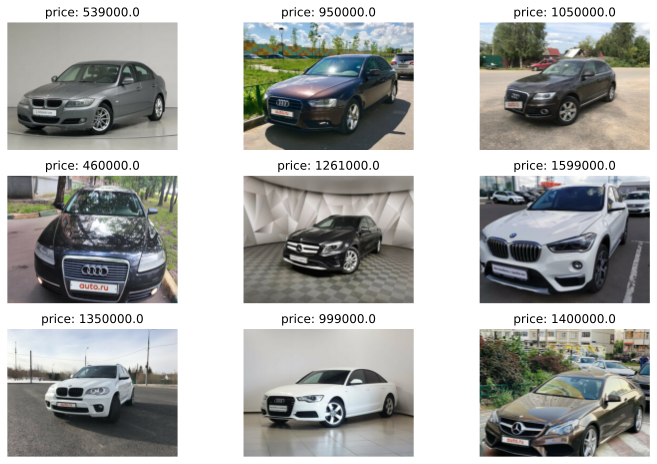

In [102]:
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR + 'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [103]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [104]:
from albumentations import (
    HorizontalFlip, 
    IAAPerspective, 
    ShiftScaleRotate, 
    CLAHE, 
    RandomRotate90,
    Transpose,
    ShiftScaleRotate, 
    Blur, 
    OpticalDistortion, 
    GridDistortion, 
    HueSaturationValue,
    IAAAdditiveGaussianNoise, 
    GaussNoise, 
    MotionBlur, 
    MedianBlur, 
    IAAPiecewiseAffine,
    IAASharpen, 
    IAAEmboss, 
    RandomBrightnessContrast, 
    Flip, 
    OneOf, 
    Compose
)

In [105]:
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

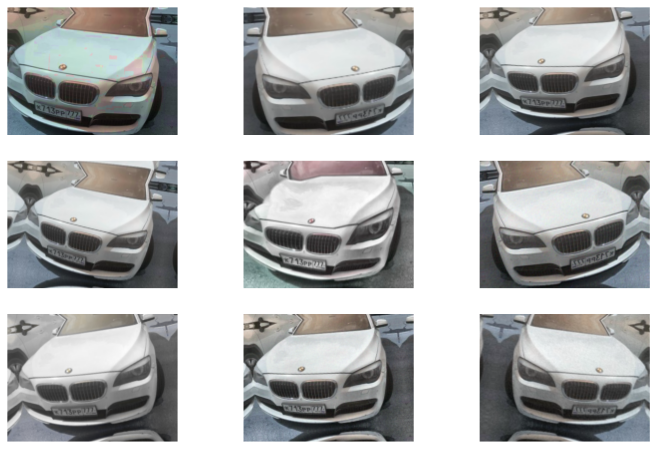

In [106]:
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [107]:
def make_augmentations(images):
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [108]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [109]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(
        tokenize.texts_to_sequences(descriptions), 
        maxlen = MAX_SEQUENCE_LENGTH
    )

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [110]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, 
    X_train, 
    data.description.iloc[X_train.index], 
    y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, 
    X_test, 
    data.description.iloc[X_test.index], 
    y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, 
    X_sub, 
    data.description.iloc[X_sub.index], 
    y_sub
)).map(tf_process_val_dataset_element)

In [111]:
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [112]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3)
)

efficientnet_output = L.GlobalAveragePooling2D()(
    efficientnet_model.output
)

43941888/43941136 [==============================] - 0s 0us/step


In [113]:
fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [114]:
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [115]:
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [116]:
combinedInput = L.concatenate([
    efficientnet_output, 
    tabular_model.output, 
    nlp_model.output
])

head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[
    efficientnet_model.input, 
    tabular_model.input, 
    nlp_model.input
], outputs=head)

In [117]:
optimizer = tf.keras.optimizers.Adam(0.005)

model.compile(
    loss='MAPE',
    optimizer=optimizer,
    metrics=['MAPE']
)

In [118]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)

earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=10, 
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(
    train_dataset.batch(30),
    epochs=100,
    validation_data=test_dataset.batch(30),
    callbacks=callbacks_list
)

Epoch 1/100
190/190 [==============================] - 2648s 14s/step - loss: 55.6342 - MAPE: 55.6342 - val_loss: 7482.1494 - val_MAPE: 7482.1494
Epoch 2/100
190/190 [==============================] - 2642s 14s/step - loss: 33.7806 - MAPE: 33.7806 - val_loss: 28.1767 - val_MAPE: 28.1767
Epoch 3/100
190/190 [==============================] - 2599s 14s/step - loss: 26.0369 - MAPE: 26.0369 - val_loss: 22.1617 - val_MAPE: 22.1617
Epoch 4/100
190/190 [==============================] - 2488s 13s/step - loss: 20.4532 - MAPE: 20.4532 - val_loss: 21.7422 - val_MAPE: 21.7422
Epoch 5/100
190/190 [==============================] - 2494s 13s/step - loss: 18.0474 - MAPE: 18.0474 - val_loss: 15.7355 - val_MAPE: 15.7355
Epoch 6/100
190/190 [==============================] - 2491s 13s/step - loss: 16.4139 - MAPE: 16.4139 - val_loss: 13.7184 - val_MAPE: 13.7184
Epoch 7/100
190/190 [==============================] - 2504s 13s/step - loss: 15.3221 - MAPE: 15.3221 - val_loss: 14.1342 - val_MAPE: 14.1342
Ep

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)
